### MTH 610 Model Constrained Optimization 1 (Homework 2)

##### Emily Bogle
##### 11/18/23

#### Kalman Filter for Mass-Spring System

We are going to consider the mass-spring system given by the second order differential equation

\begin{equation*}
x''(t)+x(t)=0
\tag{1}
\end{equation*}

with initial conditions

\begin{equation*}
x(0)=x_0, \quad x'(0)=v_0
\tag{2}
\end{equation*}

We will introduce the velocity variable $v(t)=x'(t)$, and in doing so we get the following equivalent formulation to (1-2):

\begin{equation*}
\begin{bmatrix} x' \\ v' \end{bmatrix} = \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix} \begin{bmatrix} x \\ v \end{bmatrix}, \quad \begin{bmatrix} x(0) \\ v(0) \end{bmatrix} = \begin{bmatrix} x_0 \\ v_0 \end{bmatrix}.
\tag{3}
\end{equation*}

Now we know the solution to the the IVP (3) is expressed as

\begin{equation*}
x(t)=v_0\sin(t)+x_0\cos(t), \quad v(t)=v_0\cos(t)-x_0\sin(t).
\tag{4}
\end{equation*}

This solution (4) can be put into vector format as the following:

\begin{equation}
x(t)=\begin{bmatrix} x(t) \\ v(t) \end{bmatrix},
\tag{5}
\end{equation}

where $x(t)\in\mathbb{R}^n (n=2)$ is the true state of the dynamical system. We can furthermore specify the initial condition by,

\begin{equation}
x(0)= \begin{bmatrix} x(0) \\ v(0) \end{bmatrix} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}
\tag{6}
\end{equation}

Now, we assume that we can obtain information on the true state $x(t)$ through state measurements and a time discrete model. Observations are represented as,

\begin{equation}
y=Hx+\varepsilon_O \in \mathbb{R}^m, \quad (m=1 \textrm{ or } m=2)
\tag{7}
\end{equation}

where $H\in\mathbb{R}^{m\times n}$ denotes the observation matrix and $\varepsilon_O\in\mathbb{R}^m$ is a random vector of obeservational errors. 

A time-discrete models to the true dynamics is obtained by applying the Euler's method to the system (3) with a time step $\Delta t=h$ 

$$
\hat{x}_{k+1}= M\hat{x}_{k}
\tag{8}
$$

where 

$$
M=\begin{pmatrix}1 & h \\ -h & 1 \end{pmatrix}.
\tag{9}
$$

The evolution of the true state $x_k=x(t_k)$ in (5) is given by

$$
x_{k+1}=Mx_k+w_k
\tag{10}
$$

where $w_k\in\mathbb{R}^n$ is an unknown vector consisting of numerical discretization errors. 

**We will implement the Kalman filter to estimate and predict the true state $x_k$ based on the model (8) and the observations (7). We will be using the following setup to do so:**
- A prior guess to the true (unknown) initial state at $t=0$ is presecribed as $\hat{x}_0=x(0)+\varepsilon_b$ where the initial condition error in each component is $\varepsilon_b\sim N(0,\sigma_b^2)$ with $\sigma_b^2=1$.
- The numerical discretization time step taken is $h=1$.
- The obeservational operator is defined as:
    - Case 1 (both state components are observed)
    $$ H = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \tag {11}$$
    - Case 2 (only the first state component is observed)
    $$ H = \begin{bmatrix} 1 & 0 \end{bmatrix} \tag{12}$$
- The observational error is specified as $\varepsilon_o\sim N(0,\sigma_o^2)$ with $\sigma_o=0.1$.
- Each component of the model error is specified as $w_k\sim N(0,\sigma_q^2)$ with $\sigma_q=1$.
- The time interval for the analysis is $0\le t \le t_N$, that is $k=0:N-1$ in (8). 

In [2]:
#Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

**The first thing we are going to do is investigate the performance of the discrete model in pure forecast mode.**

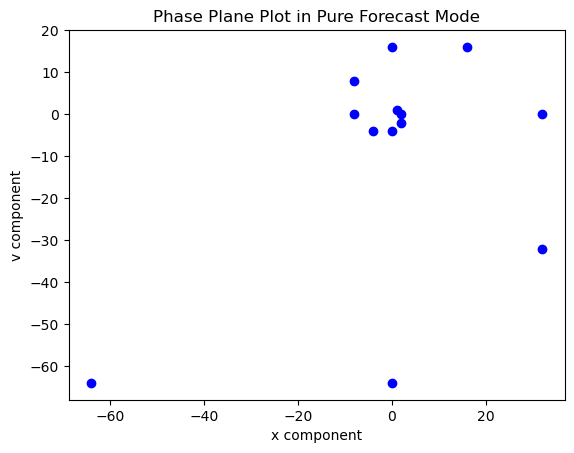

In [106]:
# Define constants
x_0 = 1
v_0 = 1
h = 1

# Initialize vectors
x = np.zeros((2,1))
x[0,0] = x_0
x[1,0] = v_0

M = np.array([[1, h],[-h, 1]])

# Pure forecast mode
xnew = x
for i in range(12):
    xnew = M @ xnew
    x = np.concatenate((x, xnew), axis=1)

# Plot pure forecast mode phase plot
plt.plot(x[0, :], x[1, :], marker='o', color='blue', linestyle='none')
plt.title('Phase Plane Plot in Pure Forecast Mode')
plt.xlabel('x component')
plt.ylabel('v component')
plt.show()

We can obviously see that in pure forecast mode the explicit Euler method does not conserve energy. The mass-spring system we are trying to model does conserve energy so we will see how much the Kalman filter can help us in predicting this mass-spring system. 

**Now, we are going to do is implement the Kalman filter with the setup above.**

In [1]:
def kalman(m):
    # Define constants
    x_0 = 1
    v_0 = 1
    h = 1

    # Initialize matrices and error vectors
    M = np.array([[1, h],[-h, 1]])
    P_a = np.identity(2)
    Q = np.identity(2)
    I = np.identity(2)
    
    if m==2:
        H = np.array([[1, 0],[0, 1]])
        R = (0.01) * np.identity(2)
    elif m==1: 
        H = np.array([[1, 0]])
        R = 0.01
    else: 
        print(f"H matrix is not defined, choose value for m = 1 or 2")
    
    epsilon_b = np.random.normal(0, 1, size=(2,))
    xa = np.array([[x_0 + epsilon_b[0]],[v_0 + epsilon_b[1]]])
    xanew = xa
    
    # Define functions for gathering the data (solution to IVP)
    def xfun(t, v_0, x_0):
        return v_0 * np.sin(t) + x_0 * np.cos(t)
    
    def vfun(t, v_0, x_0):
        return v_0 * np.cos(t) - x_0 * np.sin(t)
    
    # Create observation matrix with first inital entry
    xt_0 = xfun(0, v_0, x_0)
    vt_0 = vfun(0, v_0, x_0)
    
    truth = np.array([[xt_0],[vt_0]])
    xf = truth
    
    # Kalman Filter Iterations
    for i in range(999):
        
        # Forecast Step
        xfnew = M @ xanew
        xf = np.concatenate((xf, xfnew), axis = 1)
        P_f = M @ P_a @ M.T + Q 
        
        # Generate observation(s) at t_{k+1}
        xobscomp = xfun((i+1), v_0, x_0)
        vobscomp = vfun((i+1), v_0, x_0)
        x_obs = np.array([[xobscomp],[vobscomp]])
        
        if m==2:
            epsilon_o = np.random.normal(0, 0.1, size=(2,1))
        elif m==1:
            epsilon_o= np.random.normal(0, 0.1)
        else: 
            print(f"epsilon_o undefined, choose value for m = 1 or 2")
        
        truth = np.concatenate((truth, x_obs), axis = 1)
            
        y = H @ x_obs + epsilon_o
                             
        # Analysis Step
        K = P_f @ H.T @ np.linalg.inv(H @ P_f @ H.T + R)
        xanew = xfnew + K @ (y - H @ xfnew)
        xa = np.concatenate((xa, xanew), axis = 1)
        P_a = (I - K @ H) @ P_f
        
    ######### Output & Further Analysis ##########
        
    # Plot phase plot of observed data
    plt.plot(truth[0, :], truth[1, :], marker='.', color='blue', linestyle = 'none')
    plt.plot(xf[0, :], xf[1, :], marker='.', color='red', linestyle = 'none')
    plt.plot(xa[0, :], xa[1, :], marker='.', color='black', linestyle = 'none')
    legend_elements = [Line2D([0], [0], marker='.', color='w', markerfacecolor='blue', markersize=10, label='truth'),
                       Line2D([0], [0], marker='.', color='w', markerfacecolor='red', markersize=10, label='forecast'),
                       Line2D([0], [0], marker='.', color='w', markerfacecolor='black', markersize=10, label='analysis')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f'phase plane of truth, forecast, and analysis results, m={m}')
    plt.xlabel('x component')
    plt.ylabel('v component')
    plt.show()
    
    # Find Errors in Analysis and Forecast for each Component
    forecast_err = xf - truth
    analysis_err = xa - truth
    xf_err = np.asarray(forecast_err[0,:]).reshape(-1)
    vf_err = np.asarray(forecast_err[1,:]).reshape(-1)
    xa_err = np.asarray(analysis_err[0,:]).reshape(-1)
    va_err = np.asarray(analysis_err[1,:]).reshape(-1)

    # Plot erros in analysis and forecast for each component
    tvect = np.arange(900, 1000, 1)
    plt.plot(tvect, xf_err[900:1000], marker='.', color='red')
    plt.plot(tvect, xa_err[900:1000], marker='*', color='black')
    legend_elements = [Line2D([0], [0], marker='.', color='w', markerfacecolor='red', markersize=10, label='x_for_err'),
                       Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=10, label='x_an_err')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f'x component forecast and analysis errors, m={m}')
    plt.xlabel('t')
    plt.ylabel('error')
    plt.show()
    
    # Plot erros in analysis and forecast for each component
    tvect = np.arange(900, 1000, 1)
    plt.plot(tvect, vf_err[900:1000], marker='.', color='red')
    plt.plot(tvect, va_err[900:1000], marker='*', color='black')
    legend_elements = [Line2D([0], [0], marker='.', color='w', markerfacecolor='red', markersize=10, label='v_for_err'),
                       Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=10, label='v_an_err')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f'v component forecast and analysis errors, m={m}')
    plt.xlabel('t')
    plt.ylabel('error')
    plt.show()
    
    # Find moving averages of errors
    # Define the calculate_moving_average function
    def calculate_moving_average(errors, window_size):
        moving_averages = np.convolve(errors, np.ones(window_size)/window_size, mode='valid')
        return moving_averages

    # Set the window size
    window_size = 100

    # Calculate moving averages for each array
    moving_avg_xf_err = calculate_moving_average(np.abs(xf_err), window_size)
    moving_avg_vf_err = calculate_moving_average(np.abs(vf_err), window_size)
    moving_avg_xa_err = calculate_moving_average(np.abs(xa_err), window_size)
    moving_avg_va_err = calculate_moving_average(np.abs(va_err), window_size)

    # Plot moving average erros in analysis and forecast for each component
    tvect = np.arange(1, len(moving_avg_xf_err)+1, 1)
    plt.plot(tvect, np.abs(moving_avg_xf_err), marker='.', color='coral')
    plt.plot(tvect, np.abs(moving_avg_xa_err), marker='.', color='red')
    plt.plot(tvect, np.abs(moving_avg_vf_err), marker='.', color='grey')
    plt.plot(tvect, np.abs(moving_avg_va_err), marker='.', color='black')
    legend_elements = [Line2D([0], [0], marker='.', color='w', markerfacecolor='coral', markersize=10, label='x_for_err'),
                       Line2D([0], [0], marker='.', color='w', markerfacecolor='red', markersize=10, label='x_an_err'),
                       Line2D([0], [0], marker='.', color='w', markerfacecolor='grey', markersize=10, label='v_for_err'),
                       Line2D([0], [0], marker='.', color='w', markerfacecolor='black', markersize=10, label='v_an_err')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f'x component forecast and analysis absolute errors moving average, m={m}')
    plt.xlabel('t')
    plt.ylabel('moving average absolute error - 100 step avg')
    plt.show()

**Now we will provide a qualitative study of the analysis and forecast errors in the time interval $0\le t\le 1000$, that is for $N=1000$ time steps.**

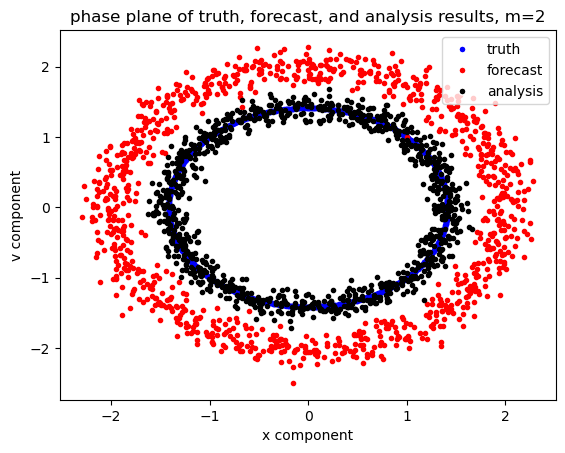

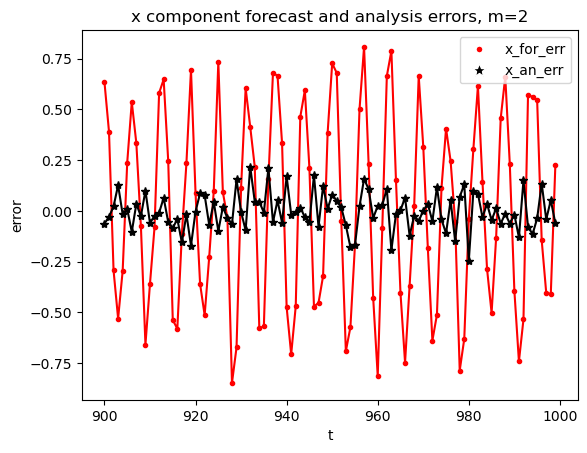

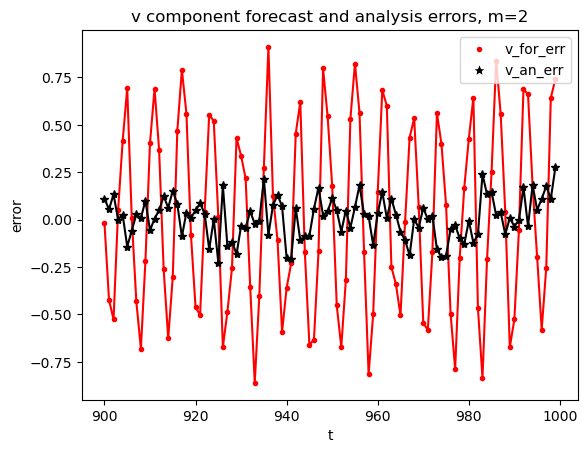

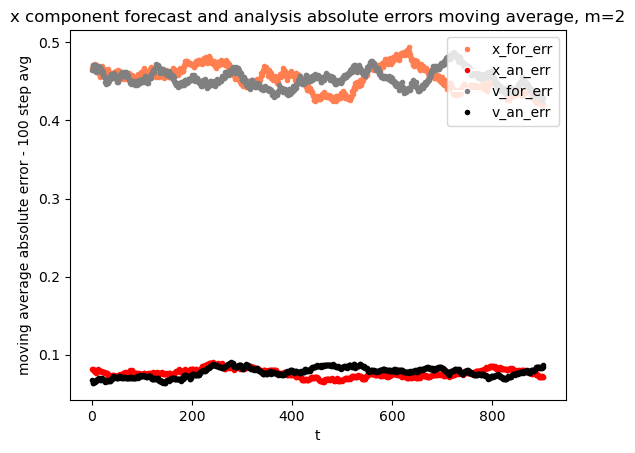

In [203]:
kalman(2)

When both components are observed in the data we can see that the analysis (predicted state after filtering) does better than the pure forecast using the model without any filtering. We also note that the magnitude of the analysis error in the first and second component, $x$ and $v$ respectively, are similar here which makes sense since we are observing both components. 

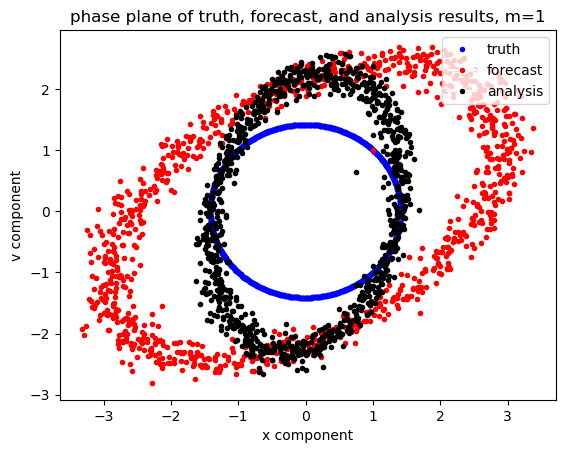

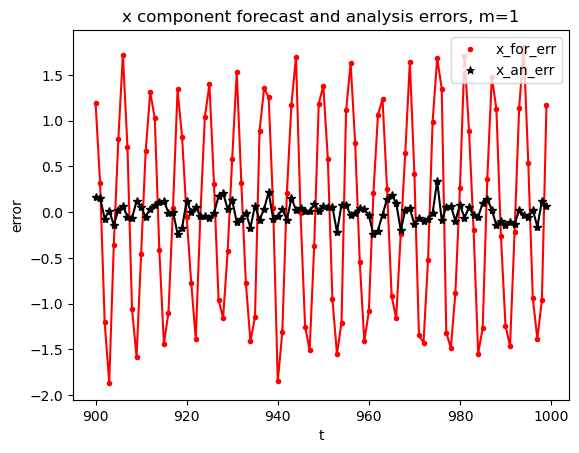

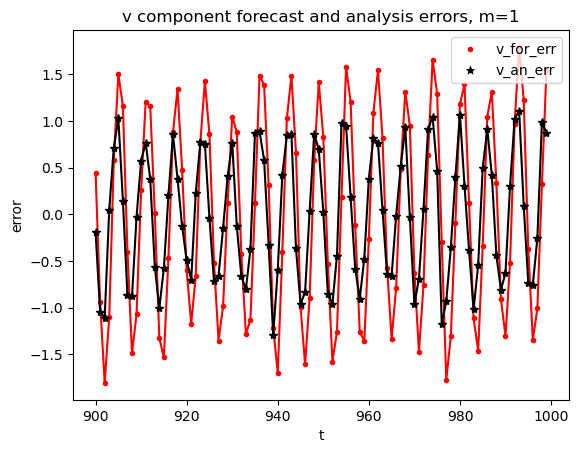

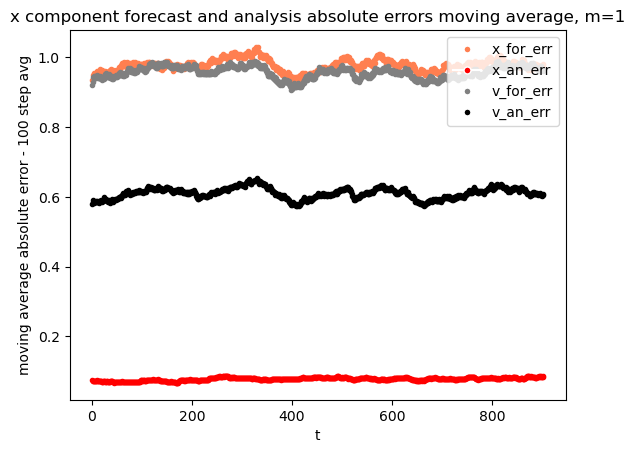

In [211]:
kalman(1)

When only the first component, $x$, is observed we see that the analysis (predicted state after filtering) still does better than the pure forecast using the model without any filtering, but it is a little less accurate than before when observing both components in the data. We also note that the magnitude of the analysis error in the first component, $x$, is significantly less than the error in the second component, $v$. This makes sense since we are using incoming information (data) pertaining to the first component in the analysis step, but there is not any incoming information about the $v$ component being used in the analysis step. 